In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
# /kaggle/input/mtpllinearregess
# -------------------------------
# Step 1: Load and Preprocess Data
# -------------------------------
data = pd.read_excel('/kaggle/input/mtpllinearregess/Data for Item Proposal_Regional-1.xlsx', sheet_name="Raw Data")

# Clean column names
data.columns = data.columns.str.replace(' ', "_")

## Clean column names
data.columns = data.columns.str.strip().str.replace(' ', '_')

# Convert 'Month' to datetime
data['Month'] = pd.to_datetime(data['Month'])
data['Month_Number'] = data['Month'].dt.month
data['Year'] = data['Month'].dt.year

# Drop 'Month' column after extracting features
data = data.drop('Month', axis=1)

# -------------------------------
# Step 2: Define Target and Safe Features
# -------------------------------
# Target variable
y = data['Net_Sales'].copy()

# Safe features only — avoid Unit_Price, Sales_Qty, Item_Name, Item_Code
# These may cause data leakage (e.g., Unit_Price × Sales_Qty = Net_Sales)
X = data[['Sales_Qty','Zone_Name', 'Depot', 'Category', 'Month_Number', 'Year']].copy()

print(f"Using features: {list(X.columns)}")
print(f"Number of samples: {len(X)}")

# -------------------------------
# Step 3: Encode Categorical Variables (One-Hot)
# -------------------------------
# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=['Zone_Name', 'Depot', 'Category'], drop_first=True)

print(f"Number of features after encoding: {X_encoded.shape[1]}")


Using features: ['Sales_Qty', 'Zone_Name', 'Depot', 'Category', 'Month_Number', 'Year']
Number of samples: 12522
Number of features after encoding: 26


In [2]:
data.columns

Index(['Zone_Name', 'Depot', 'Item_Code', 'Item_Name', 'Category',
       'Unit_Price', 'Sales', 'Sales_Qty', 'Net_Discount', 'Net_Sales',
       'Month_Number', 'Year'],
      dtype='object')

In [3]:

# Optional: Scale features (not required for accuracy, but helps interpret coefficients)
scaler = StandardScaler()
X_scaled = X_encoded.copy()
# numerical_cols = ['Month_Number', 'Year']  # Adjust based on your data
X_scaled[numerical_cols] = scaler.fit_transform(X_scaled[numerical_cols])

NameError: name 'numerical_cols' is not defined

In [4]:
# -------------------------------
# Step 3: Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 10017
Test set size: 2505


In [5]:
# -------------------------------
# Step 4: Model Training
# -------------------------------
print("\nTraining Multiple Linear Regression model...")
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)


Training Multiple Linear Regression model...


LinearRegression(n_jobs=-1)

In [6]:
# -------------------------------
# Step 5: Predictions
# -------------------------------
predictions = model.predict(X_test)


In [7]:
# -------------------------------
# Step 6: Evaluation Metrics
# -------------------------------
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / (y_test + 1e-8))) * 100  # Avoid division by zero


In [8]:
# Adjusted R²
n = len(y_test)
p = X_train.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("\n=== Multiple Linear Regression Performance ===")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


=== Multiple Linear Regression Performance ===
Mean Absolute Error (MAE): 13,852.44
Mean Squared Error (MSE): 2,158,928,474.20
Root Mean Squared Error (RMSE): 46,464.27
R² Score: 0.6532
Adjusted R²: 0.6496
Mean Absolute Percentage Error (MAPE): 94.56%


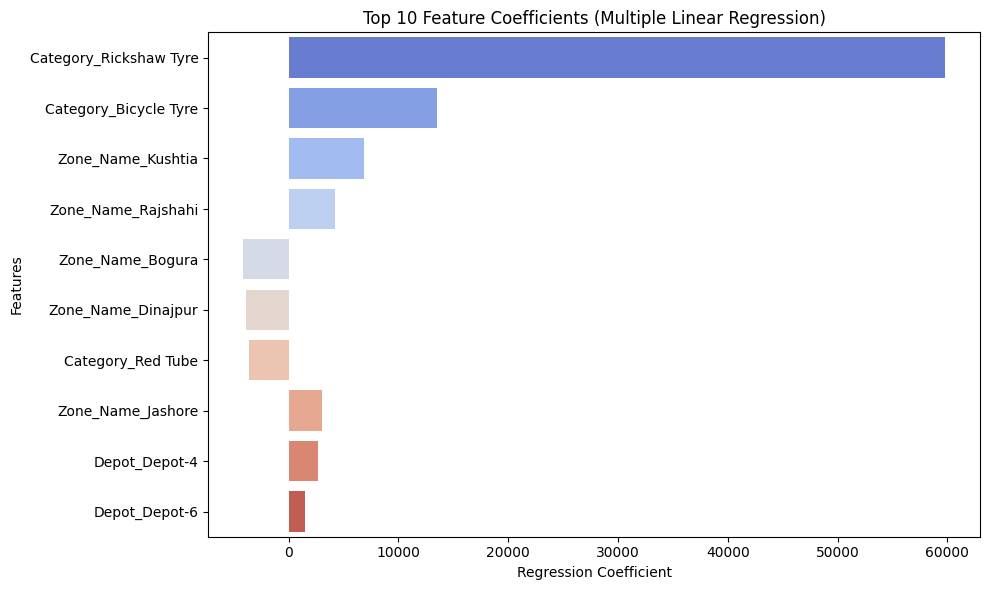

In [9]:
# Step 7: Visualizations
# -------------------------------

# 1. Coefficients (Feature Importance)
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title('Top 10 Feature Coefficients (Multiple Linear Regression)')
plt.xlabel('Regression Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

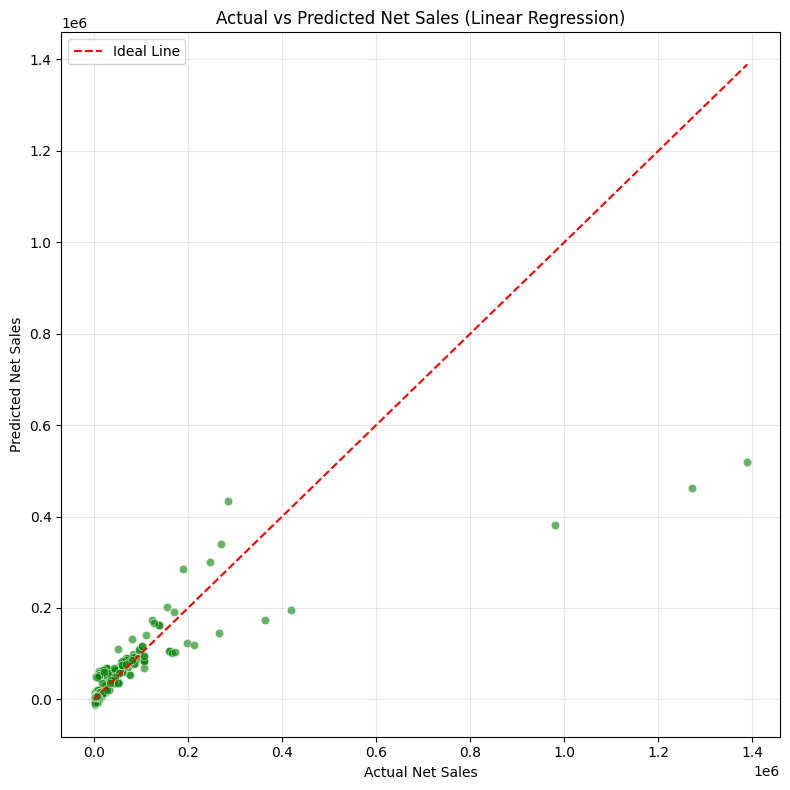

In [10]:
# 2. Actual vs Predicted Sales
comparison_df = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': predictions}).sample(500, random_state=42)
max_val = max(comparison_df['Actual'].max(), comparison_df['Predicted'].max())

plt.figure(figsize=(8, 8))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df, color='green', alpha=0.6)
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal Line')
plt.title('Actual vs Predicted Net Sales (Linear Regression)')
plt.xlabel('Actual Net Sales')
plt.ylabel('Predicted Net Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


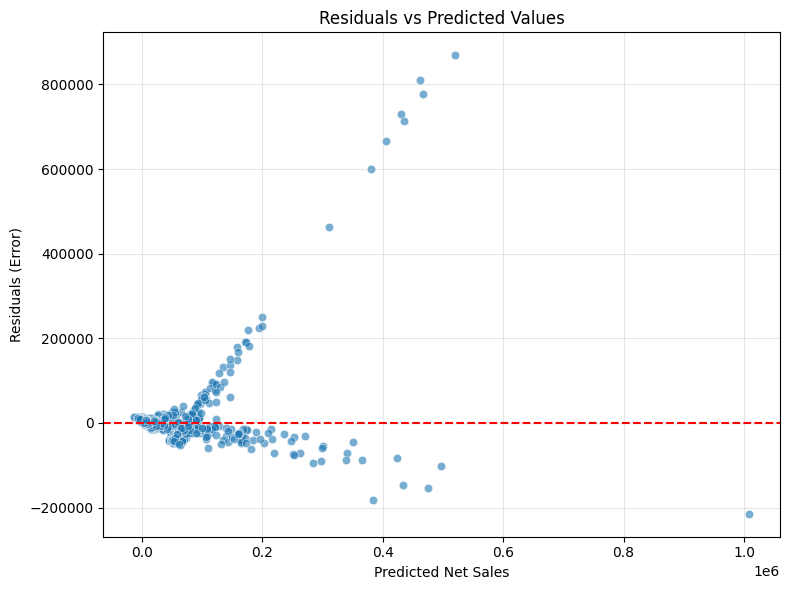

In [11]:

# 3. Residuals Plot
residuals = y_test - predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Net Sales')
plt.ylabel('Residuals (Error)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

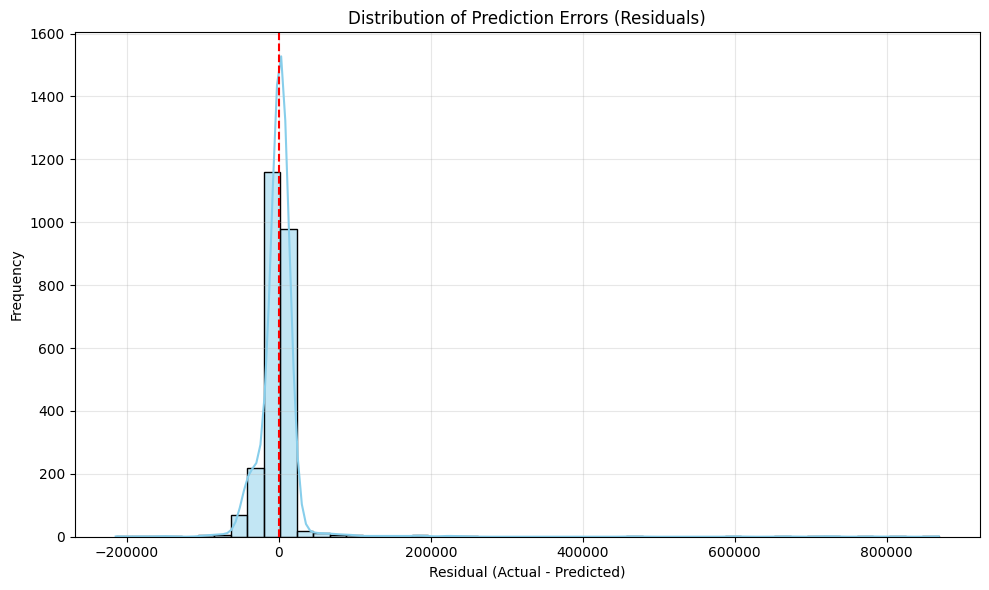

In [12]:
# 4. Residual Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# -------------------------------
# Step 8: Error Analysis
# -------------------------------
# Ensure y_test and predictions are the same length
# Debug: Check lengths
print("Debug - Lengths:")
print(f"y_test: {len(y_test)}")
print(f"predictions: {len(predictions)}")

# Ensure alignment
if len(y_test) != len(predictions):
    raise ValueError(f"Length mismatch: y_test ({len(y_test)}) vs predictions ({len(predictions)})")

# Create DataFrame safely
errors = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),           # Reset to 0-based
    'Predicted': predictions,                          # Must be same length
    'Absolute_Error': np.abs(y_test.values - predictions),
    'Percentage_Error': np.abs((y_test.values - predictions) / (y_test.values + 1e-8)) * 100
})

# Threshold: 10% of 75th percentile of actual sales
threshold = np.percentile(y_test, 75) * 0.1
large_errors = errors[errors['Absolute_Error'] > threshold]

print(f"\nData points with Absolute Error > {threshold:,.2f}: {len(large_errors)}")
print(large_errors.sort_values('Absolute_Error', ascending=False).head(10))

Debug - Lengths:
y_test: 2505
predictions: 2505

Data points with Absolute Error > 2,604.00: 1714
         Actual      Predicted  Absolute_Error  Percentage_Error
252   1389197.0  520358.301603   868838.698397         62.542512
1927  1272384.0  462342.516570   810041.483430         63.663287
86    1244160.0  467012.450572   777147.549428         62.463634
449   1159935.0  430333.927219   729601.072781         62.900169
583   1148198.0  435824.983166   712373.016834         62.042698
1070  1070324.0  404799.565414   665524.434586         62.179717
1609   980294.0  381230.548342   599063.451658         61.110590
1842   775526.0  311522.173096   464003.826904         59.830854
669    448128.0  198894.873180   249233.126820         55.616504
1883   430060.0  200348.662871   229711.337129         53.413788


In [14]:
# Percentage within 10% of average sales
mean_sales = y_test.mean()
within_10_percent = errors[errors['Absolute_Error'] <= 0.1 * mean_sales]
accuracy_rate = (len(within_10_percent) / len(errors)) * 100
print(f"\nPercentage of predictions within ±10% of average sales: {accuracy_rate:.2f}%")


Percentage of predictions within ±10% of average sales: 34.29%


In [15]:
print("Sales Statistics (y_test):")
print(y_test.describe())

Sales Statistics (y_test):
count    2.505000e+03
mean     2.998298e+04
std      7.891881e+04
min      1.269000e+03
25%      5.244000e+03
50%      1.071400e+04
75%      2.604000e+04
max      1.389197e+06
Name: Net_Sales, dtype: float64


In [16]:
# Convert to clean arrays with no index issues
actuals_clean = y_test.reset_index(drop=True).values
preds_clean = predictions  # Already a numpy array, should be length 2505

# Now create DataFrame safely
errors_head = pd.DataFrame({
    'Actual': actuals_clean,
    'Predicted': preds_clean,
    'Error': np.abs(actuals_clean - preds_clean),
    'Pct_Error': np.abs((actuals_clean - preds_clean) / actuals_clean) * 100
}).head(10)

print("First 10 predictions (Actual vs Predicted):")
print(errors_head)

First 10 predictions (Actual vs Predicted):
    Actual     Predicted         Error   Pct_Error
0  31795.0  58498.477511  26703.477511   83.986405
1  40996.0  37077.516293   3918.483707    9.558210
2   5700.0  -3573.512961   9273.512961  162.693210
3   3572.0   4081.692592    509.692592   14.269110
4  25575.0  20778.425567   4796.574433   18.754934
5  32314.0  67976.355581  35662.355581  110.361935
6  20445.0  16087.703079   4357.296921   21.312286
7  26740.0  22342.760090   4397.239910   16.444427
8   6045.0  17257.952130  11212.952130  185.491350
9   4650.0   7974.693250   3324.693250   71.498780


In [17]:
# Add predictions back to test set
X_test_clean = X_test.reset_index(drop=True)

# Show relevant features
print("Features in model (sample):")
print(X_test_clean.columns.tolist()[:10])  # First few

# Compute reconstructed sales
if 'Unit_Price' in X_test_clean.columns and 'Sales_Qty' in X_test_clean.columns:
    X_test_clean['Reconstructed'] = X_test_clean['Unit_Price'] * X_test_clean['Sales_Qty']
    errors['Reconstructed'] = X_test_clean['Reconstructed']

    # Compare reconstructed vs actual
    diff = np.abs(errors['Actual'] - errors['Reconstructed'])
    print(f"\nMax difference between Actual and Unit_Price×Qty: {diff.max():.2f}")
    print(f"Are they equal? {np.allclose(errors['Actual'], errors['Reconstructed'])}")

Features in model (sample):
['Sales_Qty', 'Month_Number', 'Year', 'Zone_Name_Bogura', 'Zone_Name_Chattogram', 'Zone_Name_Cumilla', 'Zone_Name_Dhaka City', 'Zone_Name_Dinajpur', 'Zone_Name_Gazipur', 'Zone_Name_Jashore']
